In [1]:
%matplotlib inline

import sympy as sp
sp.init_printing(use_latex ='mathjax')
import scipy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lmfit as lf
import os
import seaborn as sns
from myheatmap import myheatmap
from lmfit import Model
import lmfit
from tabulate import tabulate
import matplotlib

sns.set_context('poster') # makes text larger (poster) or smaller (paper)

In [2]:
#Define all variables

#individual springs that correspond to individual masses
k1 = sp.symbols('k_1', real = True)
k2 = sp.symbols('k_2', real = True)

#springs that connect two masses
k12 = sp.symbols('k_12', real = True)

#damping coefficients
g1 = sp.symbols('g', real = True)
g2 = sp.symbols('g2', real = True)
 
#masses
m1 = sp.symbols('m1', real = True)
m2 = sp.symbols('m2', real = True)

#Driving force amplitude
F = sp.symbols('F', real = True)

#driving frequency (leave as variable)
wd = sp.symbols('\omega_d', real = True)

In [3]:
#Solve for driving amplitudes and phase

#Matrix for complex equations of motion
driven = sp.Matrix([[-wd**2*m1 + 1j*wd*g1 + k1 + k12, -k12], [-k12, -wd**2*m2 + 
  1j*wd*g2 + k2 + k12]])

#Matrices for Cramer's Rule
driven_m1 = sp.Matrix([[F, -k12], [0, -wd**2*m2 + 1j*wd*g2 + k2 + k12]])

driven_m2 = sp.Matrix([[-wd**2*m1 + 1j*wd*g1 + k1 + k12, F], [-k12, 0]])

#Apply Cramer's Rule
Cr1, Cr2 = (driven_m1.det()/driven.det(), driven_m2.det()/driven.det())

#Solve for phases for each mass
delta1 = sp.arg(Cr1)
delta2 = sp.arg(Cr2)

#Wrap phases for plots

wrap1 = (delta1)%(2*np.pi)
wrap2 = (delta2)%(2*np.pi)

#Solve for amplitude coefficients
amp1 = sp.re(Cr1)/sp.cos(delta1)
amp2 = sp.re(Cr2)/sp.cos(delta2)


#lambdify curves

c1 = sp.lambdify((wd, k1, k2, k12, g1, g2, F, m1, m2), amp1)
t1 = sp.lambdify((wd, k1, k2, k12, g1, g2, F,  m1, m2), wrap1)

c2 = sp.lambdify((wd, k1, k2, k12, g1, g2, F, m1, m2), amp2)
t2 = sp.lambdify((wd, k1, k2, k12, g1, g2, F, m1, m2), wrap2)

#define functions

def curve1(w, k_1, k_2, k_12, g1_, g2_, F_, m_1, m_2, e):
     return c1(w, k_1, k_2, k_12, g1_, g2_, F_, m_1, m_2) + e
    
def theta1(w, k_1, k_2, k_12, g1_, g2_, F_, m_1, m_2, e):
     return t1(w, k_1, k_2, k_12, g1_, g2_, F_, m_1, m_2) - 2*np.pi + e
    
def curve2(w, k_1, k_2, k_12, g1_, g2_, F_, m_1, m_2, e):
     return c2(w, k_1, k_2, k_12, g1_, g2_, F_, m_1, m_2) + e
    
def theta2(w, k_1, k_2, k_12, g1_, g2_, F_, m_1, m_2, e):
     return t2(w, k_1, k_2, k_12, g1_, g2_, F_, m_1, m_2) - 2*np.pi + e

In [4]:
#Use functions to make matrices of amplitude and phase for each resonator (with noise)

#define set values
k1_set = 12
k2_set = 27
k12_set = 1
g1_set = 1
g2_set = 0.5
F_set = 1
m1_set = 5
m2_set = 3

#define number of samples
n = 200

#define noise
amp1_noise = 0.005 * np.random.randn(n,)
phase1_noise = 0.1 * np.random.randn(n,)
amp2_noise = 0.0005 * np.random.randn(n,)
phase2_noise = 0.2 * np.random.randn(n,)

#define frequency range
drive = np.linspace(0.1, 5, num = n)

#R1_amp = curve1(drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, amp1_noise)
#R1_phase = theta1(drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, phase1_noise)
#R2_amp = curve2(drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, amp2_noise)
#R2_phase = theta2(drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, phase2_noise)

R1_amp = curve1(drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, 0)
R1_phase = theta1(drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, 0)
R2_amp = curve2(drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, 0)
R2_phase = theta2(drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, 0)

In [5]:
#Choose points for SVD

p = [50, 115]

table = []

for i in range(len(p)):
    table.append([drive[p[i]], R1_amp[p[i]], R1_phase[p[i]], R2_amp[p[i]], R2_phase[p[i]]])
    
df = pd.DataFrame(data = table, columns = ['drive', 'R1Amp', 'R1Phase', 'R2Amp', 'R2Phase'])

df

,drive,R1Amp,R1Phase,R2Amp,R2Phase
0,1.331156,0.232161,-0.314502,0.01023,-0.343835
1,2.931658,0.032842,-3.038310,0.01236,-3.622681


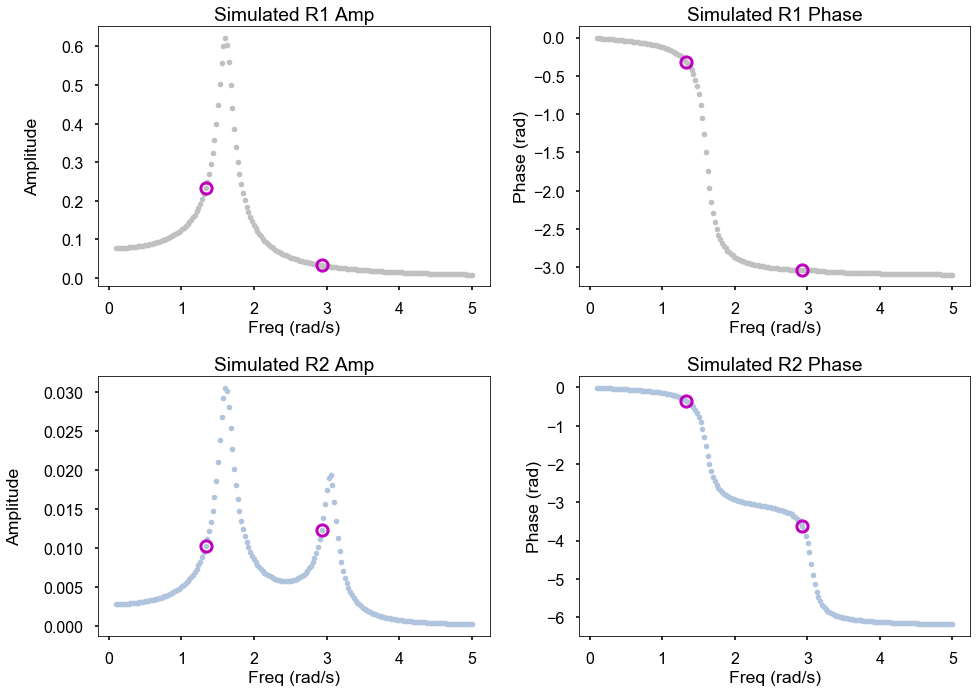

In [6]:
#Plots of singular value decomposition

sns.set_context('poster')

fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize = (14,10))

ax1.plot(drive, R1_amp, '.', color = 'silver')
ax1.set_xlabel('Freq (rad/s)')
ax1.set_ylabel('Amplitude\n')
ax1.set_title('Simulated R1 Amp')

#For loop to plot R1 amplitude values from table
for i in range(df.shape[0]):
    ax1.plot(df.drive[i], df.R1Amp[i], 'mo', fillstyle='none', markeredgewidth = 3)
        
ax2.plot(drive, R1_phase, '.', color = 'silver')
ax2.set_xlabel('Freq (rad/s)')
ax2.set_ylabel('Phase (rad)')
ax2.set_title('Simulated R1 Phase')

#For loop to plot R1 amplitude values from table
for i in range(df.shape[0]):
    ax2.plot(df.drive[i], df.R1Phase[i], 'mo', fillstyle='none', markeredgewidth = 3)
        

ax3.plot(drive, R2_amp, '.', color = 'lightsteelblue')
ax3.set_xlabel('Freq (rad/s)')
ax3.set_ylabel('Amplitude\n')
ax3.set_title('Simulated R2 Amp')

#For loop to plot R1 amplitude values from table
for i in range(df.shape[0]):
    ax3.plot(df.drive[i], df.R2Amp[i], 'mo', fillstyle='none', markeredgewidth = 3)
    

ax4.plot(drive, R2_phase, '.', color = 'lightsteelblue')
ax4.set_xlabel('Freq (rad/s)')
ax4.set_ylabel('Phase (rad)')
ax4.set_title('Simulated R2 Phase')

#For loop to plot R1 amplitude values from table
for i in range(df.shape[0]):
    ax4.plot(df.drive[i], df.R2Phase[i], 'mo', fillstyle='none', markeredgewidth = 3)
        

plt.tight_layout()

In [7]:
#Define function to calculate phase correction and complex amplitudes

ampComplex = []

def complexAmp(df):
    
    #Use amplitude and phase to calculate complex amplitude
    Z1 = df['R1Amp'] * np.exp(1j * df['R1Phase'])
    Z2 = df['R2Amp'] * np.exp(1j * df['R2Phase'])
    
    #Add complex amplitude to table to append to dataframe
    ampComplex.append([Z1, Z2])

for i in range(df.shape[0]):
    complexAmp(df.iloc[i])

df['R1AmpCom'], df['R2AmpCom'] = np.transpose(ampComplex)

df

,drive,R1Amp,R1Phase,R2Amp,R2Phase,R1AmpCom,R2AmpCom
0,1.331156,0.232161,-0.314502,0.01023,-0.343835,(0.22077398131385242-0.07181749311388894j),(0.009631369180043902-0.003448583502159697j)
1,2.931658,0.032842,-3.038310,0.01236,-3.622681,(-0.03266650506138642-0.003385922969061961j),(-0.010957152812869193+0.005719583047855916j)


In [8]:
#Singular Value Decomposition

#define which two points to use for analysis
vals1 = df.loc[0]
vals2 = df.loc[1]

#define values for svd
d1 = vals1['drive']
d1Z1 = vals1['R1AmpCom']
d1Z2 = vals1['R2AmpCom']

d2 = vals2['drive']
d2Z1 = vals2['R1AmpCom']
d2Z2 = vals2['R2AmpCom']

#Define Matrix M
M = np.array([[-d1**2*np.real(d1Z1), 0, -d1*np.imag(d1Z1), 0, np.real(d1Z1), 0, np.real(d1Z1)-np.real(d1Z2), -1],
        [-d1**2*np.imag(d1Z1), 0, d1*np.real(d1Z1), 0, np.imag(d1Z1), 0, np.imag(d1Z1)-np.imag(d1Z2), 0],
        [0, -d1**2*np.real(d1Z2), 0, -d1*np.imag(d1Z2), 0, np.real(d1Z2), np.real(d1Z2)-np.real(d1Z1), 0],
        [0, -d1**2*np.imag(d1Z2), 0, d1*np.real(d1Z2), 0, np.imag(d1Z2), np.imag(d1Z2)-np.imag(d1Z1), 0],
        [-d2**2*np.real(d2Z1), 0, -d2*np.imag(d2Z1), 0, np.real(d2Z1), 0, np.real(d2Z1)-np.real(d2Z2), -1],
        [-d2**2*np.imag(d2Z1), 0, d2*np.real(d2Z1), 0, np.imag(d2Z1), 0, np.imag(d2Z1)-np.imag(d2Z2), 0],
        [0, -d2**2*np.real(d2Z2), 0, -d2*np.imag(d2Z2), 0, np.real(d2Z2), np.real(d2Z2)-np.real(d2Z1), 0],
        [0, -d2**2*np.imag(d2Z2), 0, d2*np.real(d2Z2), 0, np.imag(d2Z2), np.imag(d2Z2)-np.imag(d2Z1), 0]])

#SVD
u, s, vh = np.linalg.svd(M, full_matrices = True)
#u, s, vh = sc.linalg.svd(M, full_matrices = False, lapack_driver = 'gesvd')

s

array([1.43257624e+00, 5.59495570e-01, 3.15186867e-01, 2.11230142e-01,
       1.04374555e-01, 3.85551329e-02, 5.07275328e-04, 6.34805308e-18])

In [9]:
vh

array([[ 7.16615795e-02+0.j, -2.80618365e-04+0.j, -5.34546664e-02+0.j,
         3.72271916e-05+0.j, -9.92678840e-02+0.j,  1.22120395e-04+0.j,
        -1.01896627e-01+0.j,  9.85783996e-01+0.j],
       [-8.61350377e-01+0.j,  6.71865347e-03+0.j, -6.42603771e-02+0.j,
        -8.65085717e-04+0.j,  3.28276110e-01+0.j, -2.85572723e-03+0.j,
         3.59707745e-01+0.j,  1.29372417e-01+0.j],
       [ 1.10811245e-01+0.j,  4.67225159e-03+0.j, -9.89189962e-01+0.j,
        -5.54871384e-04+0.j,  3.74789399e-02+0.j, -1.86613524e-03+0.j,
         7.24617925e-02+0.j, -5.04290002e-02+0.j],
       [-3.30519884e-01+0.j, -1.57603131e-01+0.j, -9.61859633e-02+0.j,
         1.58293640e-02+0.j,  1.40075848e-01+0.j,  5.57435795e-02+0.j,
        -9.11004381e-01+0.j, -6.13023500e-02+0.j],
       [-4.88995313e-02+0.j,  9.81216656e-01+0.j, -1.05576697e-02+0.j,
         1.22093686e-02+0.j,  2.05806637e-02+0.j, -1.02891831e-01+0.j,
        -1.53107990e-01+0.j, -1.04798514e-02+0.j],
       [-4.92677540e-03+0.j,  1.150

In [19]:
[M1, M2, G1, G2, K1, K2, K12, FD] = vh[4]

vals = [['Norm m1', 'Norm m2', 'Norm g1', 'Norm g2', 'Norm k1', 'Norm k2','Norm c12', 'Norm Driving Force']]
vals.append((M1, M2, G1, G2, K1, K2, K12, FD))

print(tabulate(vals, headers = 'firstrow', tablefmt = 'fancy_grid'))

╒════════════╤═══════════╤════════════╤═══════════╤═══════════╤═══════════╤════════════╤══════════════════════╕
│    Norm m1 │   Norm m2 │    Norm g1 │   Norm g2 │   Norm k1 │   Norm k2 │   Norm c12 │   Norm Driving Force │
╞════════════╪═══════════╪════════════╪═══════════╪═══════════╪═══════════╪════════════╪══════════════════════╡
│ -0.0488995 │  0.981217 │ -0.0105577 │ 0.0122094 │ 0.0205807 │ -0.102892 │  -0.153108 │           -0.0104799 │
╘════════════╧═══════════╧════════════╧═══════════╧═══════════╧═══════════╧════════════╧══════════════════════╛


/anaconda3/lib/python3.6/site-packages/tabulate.py:595: ComplexWarning: Casting complex values to real discards the imaginary part
  conv(string)
/anaconda3/lib/python3.6/site-packages/tabulate.py:996: ComplexWarning: Casting complex values to real discards the imaginary part
  return format(float(val), floatfmt)


In [20]:
#View vh array and assign variables to proper row vector

c = F_set / FD

vals2 = [['m1', 'm2', 'g1', 'g2', 'k1', 'k2','c12', 'Driving Force']]
vals2.append((M1 * c, M2 * c, G1 * c, G2 * c, K1 * c, K2 * c, K12 * c, FD * c))

print(tabulate(vals2, headers = 'firstrow', tablefmt = 'fancy_grid'))

╒═════════╤══════════╤═════════╤══════════╤══════════╤═════════╤═════════╤═════════════════╕
│      m1 │       m2 │      g1 │       g2 │       k1 │      k2 │     c12 │   Driving Force │
╞═════════╪══════════╪═════════╪══════════╪══════════╪═════════╪═════════╪═════════════════╡
│ 4.66605 │ -93.6289 │ 1.00743 │ -1.16503 │ -1.96383 │ 9.81806 │ 14.6097 │               1 │
╘═════════╧══════════╧═════════╧══════════╧══════════╧═════════╧═════════╧═════════════════╛


/anaconda3/lib/python3.6/site-packages/tabulate.py:595: ComplexWarning: Casting complex values to real discards the imaginary part
  conv(string)
/anaconda3/lib/python3.6/site-packages/tabulate.py:996: ComplexWarning: Casting complex values to real discards the imaginary part
  return format(float(val), floatfmt)


/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


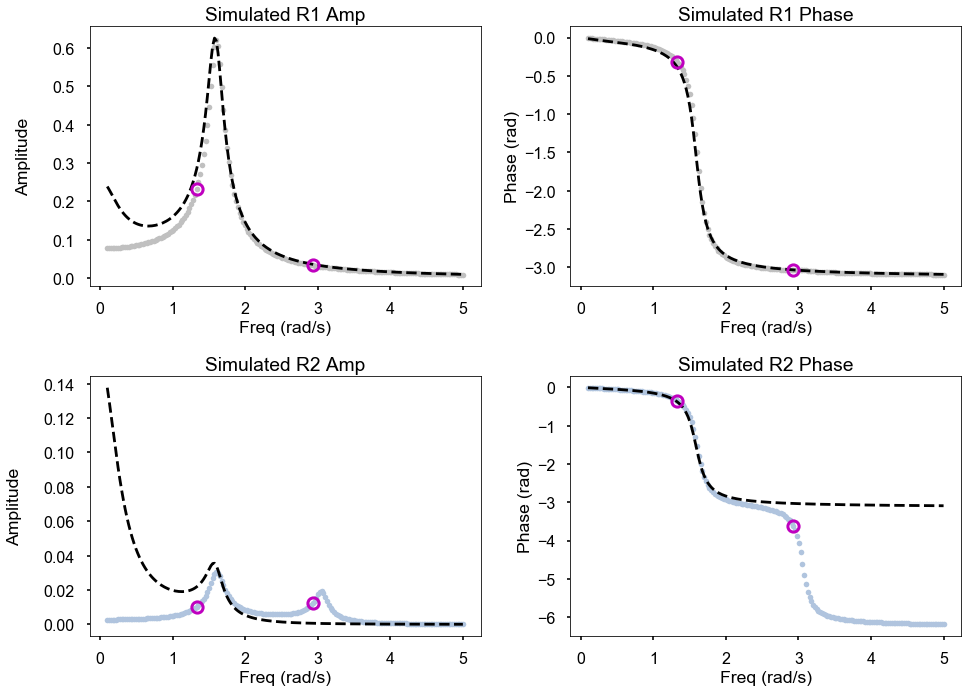

In [21]:
#Plots of singular value decomposition

sns.set_context('poster')

fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize = (14,10))

ax1.plot(drive, R1_amp, '.', color = 'silver')
ax1.plot(drive, curve1(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0), '--', color='black')
ax1.set_xlabel('Freq (rad/s)')
ax1.set_ylabel('Amplitude\n')
ax1.set_title('Simulated R1 Amp')

#For loop to plot R1 amplitude values from table
for i in range(df.shape[0]):
    ax1.plot(df.drive[i], df.R1Amp[i], 'mo', fillstyle='none', markeredgewidth = 3)
        
ax2.plot(drive, R1_phase, '.', color = 'silver')
ax2.plot(drive, theta1(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0), '--', color='black')
ax2.set_xlabel('Freq (rad/s)')
ax2.set_ylabel('Phase (rad)')
ax2.set_title('Simulated R1 Phase')

#For loop to plot R1 amplitude values from table
for i in range(df.shape[0]):
    ax2.plot(df.drive[i], df.R1Phase[i], 'mo', fillstyle='none', markeredgewidth = 3)
        

ax3.plot(drive, R2_amp, '.', color = 'lightsteelblue')
ax3.plot(drive, curve2(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0), '--', color='black')
ax3.set_xlabel('Freq (rad/s)')
ax3.set_ylabel('Amplitude\n')
ax3.set_title('Simulated R2 Amp')

#For loop to plot R1 amplitude values from table
for i in range(df.shape[0]):
    ax3.plot(df.drive[i], df.R2Amp[i], 'mo', fillstyle='none', markeredgewidth = 3)
    

ax4.plot(drive, R2_phase, '.', color = 'lightsteelblue')
ax4.plot(drive, theta2(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0), '--', color='black')
ax4.set_xlabel('Freq (rad/s)')
ax4.set_ylabel('Phase (rad)')
ax4.set_title('Simulated R2 Phase')

#For loop to plot R1 amplitude values from table
for i in range(df.shape[0]):
    ax4.plot(df.drive[i], df.R2Phase[i], 'mo', fillstyle='none', markeredgewidth = 3)
        

plt.tight_layout()

In [ ]:
#Calculate "goodness of fit" parameter

amp1_goodness = np.sum((R1_amp - curve1(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0))**2)
phase1_goodness = np.sum((R1_phase - theta1(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0))**2)
amp2_goodness = np.sum((R2_amp - curve2(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0))**2)
phase2_goodness = np.sum((R2_phase - theta2(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0))**2)

print("R1 Amp Goodness of Fit = ", amp1_goodness,
     "\nR1 Phase Goodness of Fit = ", phase1_goodness,
      "\nR2 Amp Goodness of Fit = ", amp2_goodness,
      "\nR2 Phase Goopdness of Fit = ", phase2_goodness)

**Sweep through possible point differences**

In [ ]:
#Code that loops through points of different spacing

#Define starting point and interval
start = 50
interval = 1

#initiate arrays for goodness of fit values
fits = []

#Start table with starting point
tab = [[drive[start], R1_amp[start], R1_phase[start], R2_amp[start], R2_phase[start]]]

i = 1 

while i < (n - start):
    
    #Append next data point to table and add to dataframe
    tab.append([drive[start + i], R1_amp[start + i], R1_phase[start + i], R2_amp[start + i], R2_phase[start + i]])
    
    df_vals = pd.DataFrame(data = tab, columns = ['drive', 'R1Amp', 'R1Phase', 'R2Amp', 'R2Phase'])
    
    #Calculate complex values   
    ampComplex = []
    
    Z1_1 = df_vals['R1Amp'][0] * np.exp(1j * df_vals['R1Phase'][0])
    Z2_1 = df_vals['R2Amp'][0] * np.exp(1j * df_vals['R2Phase'][0])
    
    Z1_2 = df_vals['R1Amp'][1] * np.exp(1j * df_vals['R1Phase'][1])
    Z2_2 = df_vals['R2Amp'][1] * np.exp(1j * df_vals['R2Phase'][1])
    
    ampComplex.append([Z1_1, Z2_1])
    ampComplex.append([Z1_2, Z2_2])

    df_vals['R1AmpCom'], df_vals['R2AmpCom'] = np.transpose(ampComplex)

    #define which two points to use for analysis
    vals1 = df_vals.loc[0]
    vals2 = df_vals.loc[1]

    #define values for svd
    d1 = vals1['drive']
    d1Z1 = vals1['R1AmpCom']
    d1Z2 = vals1['R2AmpCom']

    d2 = vals2['drive']
    d2Z1 = vals2['R1AmpCom']
    d2Z2 = vals2['R2AmpCom']
    
    M = np.array([[-d1**2*np.real(d1Z1), 0, -d1*np.imag(d1Z1), 0, np.real(d1Z1), 0, np.real(d1Z1)-np.real(d1Z2), -1],
        [-d1**2*np.imag(d1Z1), 0, d1*np.real(d1Z1), 0, np.imag(d1Z1), 0, np.imag(d1Z1)-np.imag(d1Z2), 0],
        [0, -d1**2*np.real(d1Z2), 0, -d1*np.imag(d1Z2), 0, np.real(d1Z2), np.real(d1Z2)-np.real(d1Z1), 0],
        [0, -d1**2*np.imag(d1Z2), 0, d1*np.real(d1Z2), 0, np.imag(d1Z2), np.imag(d1Z2)-np.imag(d1Z1), 0],
        [-d2**2*np.real(d2Z1), 0, -d2*np.imag(d2Z1), 0, np.real(d2Z1), 0, np.real(d2Z1)-np.real(d2Z2), -1],
        [-d2**2*np.imag(d2Z1), 0, d2*np.real(d2Z1), 0, np.imag(d2Z1), 0, np.imag(d2Z1)-np.imag(d2Z2), 0],
        [0, -d2**2*np.real(d2Z2), 0, -d2*np.imag(d2Z2), 0, np.real(d2Z2), np.real(d2Z2)-np.real(d2Z1), 0],
        [0, -d2**2*np.imag(d2Z2), 0, d2*np.real(d2Z2), 0, np.imag(d2Z2), np.imag(d2Z2)-np.imag(d2Z1), 0]])

    #SVD
    u, s, vh = np.linalg.svd(M, full_matrices = True)
    
    #assign variables
    [M1, M2, G1, G2, K1, K2, K12, FD] = vh[7]
    
    #calculate goodness of fit for R1 and R2 amplitudes and phases and add to arrays
    fits.append([drive[start + i] - drive[start], 
                 np.sum(R1_amp - curve1(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0))**2, 
                np.sum((R1_phase - theta1(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0))**2),
                np.sum((R2_amp - curve2(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0))**2),
                np.sum((R2_phase - theta2(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0))**2)])
    
    #remove data from table and dataframe to start over
    tab.pop()
    
    i = i + interval
    
diffs = pd.DataFrame(data = fits, columns = ['Difference', 'R1AmpFit', 'R1PhaseFit', 'R2AmpFit', 'R2PhaseFit'])

In [ ]:
#Plots of goodness of fits as a function of seperation between points
sns.set_context('poster')

fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize = (14,10))

ax1.plot(diffs.Difference, (diffs.R1AmpFit), '.', color = 'silver')
ax1.set_xlabel('Frequency Difference (rad/s)')
ax1.set_ylabel('Difference Squared ($m^2$)')
ax1.set_title('R1 Amp Goodness of Fit')
        
ax2.plot(diffs.Difference, (diffs.R1PhaseFit), '.', color = 'silver')
ax2.set_xlabel('Frequency Difference (rad/s)')
ax2.set_ylabel('Difference Squared ($rad^2$)')
ax2.set_title('R1 Phase Goodness of Fit')     

ax3.plot(diffs.Difference, (diffs.R2AmpFit), '.', color = 'lightsteelblue')
ax3.set_xlabel('Frequency Difference (rad/s)')
ax3.set_ylabel('Difference Squared ($m^2$)')
ax3.set_title('R2 Amp Goodness of Fit')
    
ax4.plot(diffs.Difference, (diffs.R2PhaseFit), '.', color = 'lightsteelblue')
ax4.set_xlabel('Frequency Difference (rad/s)')
ax4.set_ylabel('Difference Squared ($rad^2$)')
ax4.set_title('R2 Phase Goodness of Fit')
        
plt.tight_layout()

#Print frequency difference with smallest goodness of fit

print("R1 Amp min = ", diffs.iloc[diffs.R1AmpFit.idxmin()].Difference, "m",
     "\nR1 Phase min = ", diffs.iloc[diffs.R1PhaseFit.idxmin()].Difference, "rad",
     "\nR2 Amp min = ", diffs.iloc[diffs.R2AmpFit.idxmin()].Difference, "m",
     "\nR2 Phase min = ", diffs.iloc[diffs.R2PhaseFit.idxmin()].Difference, "rad")

In [ ]:
#Plot combined amplitude and phase Goodness of Fit parameters

#Plots of goodness of fits as a function of seperation between points
sns.set_context('poster')

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (14,5))

ax1.plot(diffs.Difference, (diffs.R1AmpFit)+(diffs.R2AmpFit), '.', color = 'silver')
ax1.set_xlabel('Frequency Difference (rad/s)')
ax1.set_ylabel('Difference Squared ($m^2$)')
ax1.set_title('Amplitude Goodness of Fit')
        
ax2.plot(diffs.Difference, (diffs.R1PhaseFit)+(diffs.R2PhaseFit), '.', color = 'silver')
ax2.set_xlabel('Frequency Difference (rad/s)')
ax2.set_ylabel('Difference Squared ($rad^2$)')
ax2.set_title('Phase Goodness of Fit')     

plt.tight_layout()

#Print frequency difference with smallest goodness of fit

print("Amp min = ", diffs.iloc[diffs.R1AmpFit.idxmin()].Difference + 
      diffs.iloc[diffs.R2AmpFit.idxmin()].Difference, "m",
     "\nR1 Phase min = ", diffs.iloc[diffs.R1PhaseFit.idxmin()].Difference +
      diffs.iloc[diffs.R2PhaseFit.idxmin()].Difference, "rad")

In [ ]:
#Plots of goodness of fits as a function of seperation between points
sns.set_context('poster')

fig, (ax1) = plt.subplots(1, 1, figsize = (8,6))

ax1.plot(diffs.Difference, np.log(diffs.R1AmpFit + diffs.R2AmpFit + diffs.R1PhaseFit + diffs.R2PhaseFit), '.', color = 'silver')
ax1.set_xlabel('Frequency Difference (rad/s)')
ax1.set_ylabel('Log Difference Squared ($m^2$)')
ax1.set_title('Total Goodness of Fit')

print("Total min = ", diffs.iloc[(diffs.R1AmpFit + diffs.R2AmpFit + diffs.R1PhaseFit + diffs.R2PhaseFit).idxmin()].Difference, "rad/s")

**Sweep through starting points**

In [ ]:
#Code that loops through points of different spacing

interval = 10

j = 1

max_vals = []

while j < (n - interval):
    
    #Define starting point and interval
    start = j


    #initiate arrays for goodness of fit values
    fits = []

    #Start table with starting point
    tab = [[drive[start], R1_amp[start], R1_phase[start], R2_amp[start], R2_phase[start]]]

    i = 1 

    while i < (n - start):
    
        #Append next data point to table and add to dataframe
        tab.append([drive[start + i], R1_amp[start + i], R1_phase[start + i], R2_amp[start + i], R2_phase[start + i]])
    
        df_vals = pd.DataFrame(data = tab, columns = ['drive', 'R1Amp', 'R1Phase', 'R2Amp', 'R2Phase'])
    
        #Calculate complex values   
        ampComplex = []
    
        Z1_1 = df_vals['R1Amp'][0] * np.exp(1j * df_vals['R1Phase'][0])
        Z2_1 = df_vals['R2Amp'][0] * np.exp(1j * df_vals['R2Phase'][0])
    
        Z1_2 = df_vals['R1Amp'][1] * np.exp(1j * df_vals['R1Phase'][1])
        Z2_2 = df_vals['R2Amp'][1] * np.exp(1j * df_vals['R2Phase'][1])
    
        ampComplex.append([Z1_1, Z2_1])
        ampComplex.append([Z1_2, Z2_2])

        df_vals['R1AmpCom'], df_vals['R2AmpCom'] = np.transpose(ampComplex)

        #define which two points to use for analysis
        vals1 = df_vals.loc[0]
        vals2 = df_vals.loc[1]

        #define values for svd
        d1 = vals1['drive']
        d1Z1 = vals1['R1AmpCom']
        d1Z2 = vals1['R2AmpCom']

        d2 = vals2['drive']
        d2Z1 = vals2['R1AmpCom']
        d2Z2 = vals2['R2AmpCom']
    
        M = np.array([[-d1**2*np.real(d1Z1), 0, -d1*np.imag(d1Z1), 0, np.real(d1Z1), 0, np.real(d1Z1)-np.real(d1Z2), -1],
            [-d1**2*np.imag(d1Z1), 0, d1*np.real(d1Z1), 0, np.imag(d1Z1), 0, np.imag(d1Z1)-np.imag(d1Z2), 0],
            [0, -d1**2*np.real(d1Z2), 0, -d1*np.imag(d1Z2), 0, np.real(d1Z2), np.real(d1Z2)-np.real(d1Z1), 0],
            [0, -d1**2*np.imag(d1Z2), 0, d1*np.real(d1Z2), 0, np.imag(d1Z2), np.imag(d1Z2)-np.imag(d1Z1), 0],
            [-d2**2*np.real(d2Z1), 0, -d2*np.imag(d2Z1), 0, np.real(d2Z1), 0, np.real(d2Z1)-np.real(d2Z2), -1],
            [-d2**2*np.imag(d2Z1), 0, d2*np.real(d2Z1), 0, np.imag(d2Z1), 0, np.imag(d2Z1)-np.imag(d2Z2), 0],
            [0, -d2**2*np.real(d2Z2), 0, -d2*np.imag(d2Z2), 0, np.real(d2Z2), np.real(d2Z2)-np.real(d2Z1), 0],
            [0, -d2**2*np.imag(d2Z2), 0, d2*np.real(d2Z2), 0, np.imag(d2Z2), np.imag(d2Z2)-np.imag(d2Z1), 0]])

        #SVD
        u, s, vh = np.linalg.svd(M, full_matrices = True)
    
        #assign variables
        [M1, M2, G1, G2, K1, K2, K12, FD] = vh[7]
    
        #calculate goodness of fit for R1 and R2 amplitudes and phases and add to arrays
        max_vals.append([drive[start], drive[start + i] - drive[start], 
                np.sum(R1_amp - curve1(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0))**2 + 
                np.sum((R1_phase - theta1(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0))**2) +
                np.sum((R2_amp - curve2(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0))**2) +
                np.sum((R2_phase - theta2(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0))**2)])
    
        #remove data from table and dataframe to start over
        tab.pop()
    
        i = i + interval
        
    j = j + interval
    
maxes = pd.DataFrame(data = max_vals, columns = ['Starting Freq', 'FreqDiff', 'TotalFit'])

In [ ]:
#maxes

In [ ]:
#Plots of goodness of fits as a function of seperation between points
sns.set_context('poster')

fig, (ax1) = plt.subplots(1, 1, figsize = (8,6))

ax1.plot(maxes.FreqDiff, (maxes.TotalFit), '.', color = 'silver')
ax1.set_xlabel('Frequency Difference (rad/s)')
ax1.set_ylabel('Difference Squared ($m^2$)')
ax1.set_title('Total Goodness of Fit')

# Sweep error to see affect of difference squared values

In [ ]:
#define points for SVD

points = [50, 70]

#define drive frequencies
drive = np.linspace(0.1, 5, num = n)

results = []

i = 0

interval = 0.001

while i < 0.05 :

    #Amplitudes and phases with no error
    R1amp = curve1(drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, 0)
    R1phase = theta1(drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, 0)
    R2amp = curve2(drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, 0)
    R2phase = theta2(drive, k1_set, k2_set, k12_set, g1_set, g2_set, F_set, m1_set, m2_set, 0)

    #Put amplitude and phase values in table and add error
    tabl = []
    
    for j in range(len(points)):
        tabl.append([drive[points[j]], R1amp[points[j]] + i, R1amp[points[j]] + i,
                      R2amp[points[j]] + i, R2amp[points[j]] + i])

    df = pd.DataFrame(data = tabl, columns = ['drive', 'R1Amp', 'R1Phase', 'R2Amp', 'R2Phase'])

    #Define complex amplitudes
    #Define function to calculate phase correction and complex amplitudes

    ampComplex = []

    def complexAmp(df):

        #Use amplitude and phase to calculate complex amplitude
        Z1 = df['R1Amp'] * np.exp(1j * df['R1Phase'])
        Z2 = df['R2Amp'] * np.exp(1j * df['R2Phase'])

        #Add complex amplitude to table to append to dataframe
        ampComplex.append([Z1, Z2])

    for j in range(df.shape[0]):
        complexAmp(df.iloc[j])

    df['R1AmpCom'], df['R2AmpCom'] = np.transpose(ampComplex)
    
    #Singular Value Decomposition

    #define which two points to use for analysis
    vals1 = df.loc[0]
    vals2 = df.loc[1]

    #define values for svd
    d1 = vals1['drive']
    d1Z1 = vals1['R1AmpCom']
    d1Z2 = vals1['R2AmpCom']

    d2 = vals2['drive']
    d2Z1 = vals2['R1AmpCom']
    d2Z2 = vals2['R2AmpCom']

    #Define Matrix M
    M = np.array([[-d1**2*np.real(d1Z1), 0, -d1*np.imag(d1Z1), 0, np.real(d1Z1), 0, np.real(d1Z1)-np.real(d1Z2), -1],
            [-d1**2*np.imag(d1Z1), 0, d1*np.real(d1Z1), 0, np.imag(d1Z1), 0, np.imag(d1Z1)-np.imag(d1Z2), 0],
            [0, -d1**2*np.real(d1Z2), 0, -d1*np.imag(d1Z2), 0, np.real(d1Z2), np.real(d1Z2)-np.real(d1Z1), 0],
            [0, -d1**2*np.imag(d1Z2), 0, d1*np.real(d1Z2), 0, np.imag(d1Z2), np.imag(d1Z2)-np.imag(d1Z1), 0],
            [-d2**2*np.real(d2Z1), 0, -d2*np.imag(d2Z1), 0, np.real(d2Z1), 0, np.real(d2Z1)-np.real(d2Z2), -1],
            [-d2**2*np.imag(d2Z1), 0, d2*np.real(d2Z1), 0, np.imag(d2Z1), 0, np.imag(d2Z1)-np.imag(d2Z2), 0],
            [0, -d2**2*np.real(d2Z2), 0, -d2*np.imag(d2Z2), 0, np.real(d2Z2), np.real(d2Z2)-np.real(d2Z1), 0],
            [0, -d2**2*np.imag(d2Z2), 0, d2*np.real(d2Z2), 0, np.imag(d2Z2), np.imag(d2Z2)-np.imag(d2Z1), 0]])

    #SVD
    u, s, vh = np.linalg.svd(M, full_matrices = True)
    #u, s, vh = sc.linalg.svd(M, full_matrices = False, lapack_driver = 'gesvd')

    
     #assign variables
    [M1, M2, G1, G2, K1, K2, K12, FD] = vh[7]
    
    #calculate goodness of fit for R1 and R2 amplitudes and phases and add to arrays
    results.append([drive[points[1]] - drive[points[0]], i,
                np.sum(R1amp - curve1(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0))**2, 
                np.sum((R1phase - theta1(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0))**2),
                np.sum((R2amp - curve2(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0))**2),
                np.sum((R2phase - theta2(drive, K1, K2, K12, G1, G2, FD, M1, M2, 0))**2)])
    
    #remove data from table and dataframe to start over
    tabl.pop()
    
    i = i + interval
    
errors = pd.DataFrame(data = results, columns = ['Difference','error', 'R1AmpFit', 'R1PhaseFit', 'R2AmpFit', 'R2PhaseFit'])

In [ ]:
#Plot combined amplitude and phase Goodness of Fit parameters

#Plots of goodness of fits as a function of seperation between points
sns.set_context('poster')

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (14,5))

ax1.plot(errors.error, (errors.R1AmpFit)+(errors.R2AmpFit), '.', color = 'silver')
ax1.set_xlabel('Error')
ax1.set_ylabel('Difference Squared ($m^2$)')
ax1.set_title('Amplitude Goodness of Fit')
        
ax2.plot(errors.error, (errors.R1PhaseFit)+(errors.R2PhaseFit), '.', color = 'silver')
ax2.set_xlabel('Error')
ax2.set_ylabel('Difference Squared ($rad^2$)')
ax2.set_title('Phase Goodness of Fit')     

plt.tight_layout()